# 0. Install Dependencies and Bring in Data

In [1]:
# %pip install tensorflow pandas matplotlib scikit-learn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('data', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.iloc[100]['comment_text']

'However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny'

In [6]:
df[df.columns[2:]].iloc[100]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 100, dtype: int64

In [7]:
df[df['identity_hate']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1


# 1. Preprocess

In [8]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    3.0.0
astunparse                   1.6.3
cachetools                   5.5.2
certifi                      2025.1.31
charset-normalizer           3.4.1
colorama                     0.4.6
comm                         0.2.2
debugpy                      1.8.12
decorator                    5.2.1
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  25.2.10
gast                         0.4.0
google-auth                  2.38.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.70.0
h5py                         3.13.0
idna                         3.10
importlib_metadata           8.6.1
ipykernel                    6.29.5
ipython                      8.33.0
jedi                         0.19.2
jupyter_client               8.6.3
jupyter_core                 5.7.2


In [9]:
from tensorflow.keras.layers import TextVectorization

In [10]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_FEATURES = 200000 # number of words in the vocab

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [13]:
# TextVectorization??
vectorizer??

Signature:      vectorizer(*args, **kwargs)
Type:           TextVectorization
String form:    <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001EB84DC2FB0>
File:           c:\programdata\anaconda3\envs\py310\lib\site-packages\keras\layers\preprocessing\text_vectorization.py
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[],
)
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is meant to handle natural
    language i

In [14]:
vectorizer.adapt(X.values)

In [15]:
print(vectorizer)

In [16]:
vectorized_text = vectorizer(X.values)

In [17]:
#MCSHBAP - map, cache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = (
    tf.data.Dataset.from_tensor_slices((vectorized_text, y))
      .cache()
      .shuffle(160000)
      .batch(16)
      .prefetch(tf.data.AUTOTUNE)
)

In [18]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [19]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))






Num GPUs Available: 1


In [21]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [22]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='Adam')

In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [25]:
history = model.fit(train, epochs=8, validation_data=val)

Epoch 1/8
6981/6981 [==============================] - 1423s 204ms/step - loss: 0.0558 - val_loss: 0.0462
Epoch 2/8
6981/6981 [==============================] - 1437s 206ms/step - loss: 0.0449 - val_loss: 0.0397
Epoch 3/8
6981/6981 [==============================] - 1414s 202ms/step - loss: 0.0403 - val_loss: 0.0346
Epoch 4/8
6981/6981 [==============================] - 1399s 200ms/step - loss: 0.0360 - val_loss: 0.0309
Epoch 5/8
6981/6981 [==============================] - 1430s 205ms/step - loss: 0.0318 - val_loss: 0.0281
Epoch 6/8
6981/6981 [==============================] - 1415s 203ms/step - loss: 0.0290 - val_loss: 0.0257
Epoch 7/8
6981/6981 [==============================] - 1430s 205ms/step - loss: 0.0259 - val_loss: 0.0236
Epoch 8/8
6981/6981 [==============================] - 1427s 204ms/step - loss: 0.0240 - val_loss: 0.0211


In [29]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

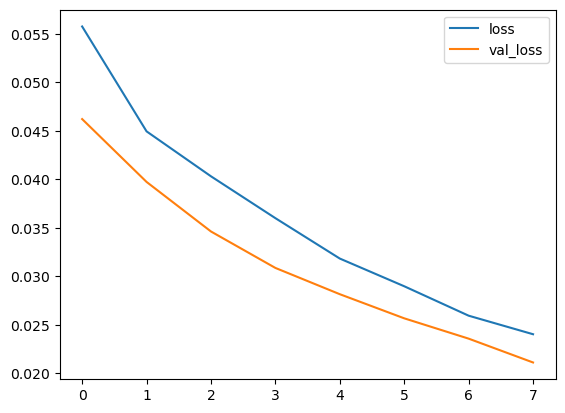

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [31]:
input_text = vectorizer("You are a piece of shit.")

In [32]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


In [33]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [34]:
print(res)

[[0.8580662  0.00132763 0.05927214 0.00606199 0.38065934 0.03719698]]


In [35]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [36]:
batch=test.as_numpy_iterator().next()

In [37]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [38]:
model.predict(batch_X)

1/1 [==============================] - 0s 137ms/step


array([[9.57473912e-06, 3.28933608e-29, 5.27829684e-07, 3.12406039e-11,
        1.35718663e-08, 3.36442267e-12],
       [2.63777071e-08, 0.00000000e+00, 1.05164855e-09, 1.00421209e-16,
        1.18987784e-12, 1.36513711e-18],
       [4.81320441e-08, 0.00000000e+00, 1.83439619e-09, 3.08979434e-16,
        3.13626794e-12, 5.60717530e-18],
       [6.63401783e-02, 1.65136049e-09, 3.34102963e-03, 4.03448852e-04,
        3.88681679e-03, 7.02026591e-04],
       [2.24754558e-06, 2.78218942e-32, 1.44887551e-07, 8.84812351e-13,
        1.31024136e-09, 4.72101335e-14],
       [3.61230320e-07, 3.65678856e-37, 1.03565085e-08, 2.42789916e-14,
        8.49847762e-11, 1.06887681e-15],
       [3.45275403e-05, 3.25925186e-26, 2.08035749e-06, 4.33203112e-10,
        1.04836509e-07, 5.97656369e-11],
       [8.74470830e-01, 6.05238555e-03, 1.61000893e-01, 1.45877451e-02,
        6.67891443e-01, 1.00170776e-01],
       [9.99762237e-01, 4.29167271e-01, 9.98755097e-01, 6.48698956e-02,
        9.82385993e-01, 

In [39]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 175ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [40]:
res.shape

(1, 6)

# 4. Evaluate Model

In [41]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [42]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [43]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 98ms/step


In [44]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8913641571998596, Recall:0.904296875, Accuracy:0.4964894652366638


# 5. Test and Gradio

In [42]:
# serialize model to JSON
# model_json = model.to_json()

In [43]:
# with open("modelepoch5.json", "w") as json_file:
#     json_file.write(model_json)

In [44]:
# from tensorflow.keras.models import model_from_json
# model_architecture=model_from_json(model_json)

In [45]:
# model_architecture.summary()

In [46]:
# serialize weights to HDF5
# model.save_weights("modelepoch5.weights.h5")

In [48]:
model.save("C:/Users/NitishSharma/Desktop/comment_toxicity_lstm/model/output_1/toxicity_epoch8.keras")

In [49]:
reconstructed_model = tf.keras.models.load_model('C:/Users/NitishSharma/Desktop/comment_toxicity_lstm/model/output_1/toxicity_epoch8.keras')

In [50]:
input_str = vectorizer('I love you.')

In [51]:
print(input_str)

tf.Tensor([  8 454   7 ...   0   0   0], shape=(1800,), dtype=int64)


In [58]:
res = reconstructed_model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 704ms/step


In [53]:
res

array([[3.0345026e-02, 4.5318574e-10, 4.1412339e-03, 5.3007028e-04,
        3.1782012e-03, 3.3271493e-04]], dtype=float32)

In [59]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    print(vectorized_comment)
    results = reconstructed_model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx])
    new_df = pd.DataFrame(columns=df.columns[2:], data=results)
    print(new_df.head)
    return results

In [60]:
score_comment('Men are good people')

tf.Tensor([[1118   20   98 ...    0    0    0]], shape=(1, 1800), dtype=int64)
1/1 [==============================] - 0s 147ms/step
<bound method NDFrame.head of       toxic  severe_toxic       obscene        threat        insult  \
0  0.000007  2.303179e-28  3.721848e-07  2.295252e-12  6.372932e-09   

   identity_hate  
0   6.005487e-14  >


array([[6.9475782e-06, 2.3031794e-28, 3.7218481e-07, 2.2952519e-12,
        6.3729315e-09, 6.0054873e-14]], dtype=float32)

In [54]:
# !pip install gradio jinja2

In [61]:
import gradio as gr

c:\ProgramData\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
interface = gr.Interface(fn=score_comment, inputs="textbox", outputs='text')

In [63]:
interface.launch(share=True)

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\gradio\routes.py", line 585, in main
    resp = templates.TemplateResponse(
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 208, in TemplateResponse
    template = self.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 131, in get_template
    return self.env.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 1016, in get_template
    return self._load_template(name, globals)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 975, in _load_template
    template = self.loader.load(self, name, self.make_globals(globals))
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\loaders.py", line 126, in load
    source, filename, uptodate =

* Running on local URL:  http://127.0.0.1:7860


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\gradio\routes.py", line 585, in main
    resp = templates.TemplateResponse(
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 208, in TemplateResponse
    template = self.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 131, in get_template
    return self.env.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 1016, in get_template
    return self._load_template(name, globals)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 975, in _load_template
    template = self.loader.load(self, name, self.make_globals(globals))
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\loaders.py", line 126, in load
    source, filename, uptodate =

* Running on public URL: https://263e6ae0194f3d2ca8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\gradio\routes.py", line 585, in main
    resp = templates.TemplateResponse(
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 208, in TemplateResponse
    template = self.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\starlette\templating.py", line 131, in get_template
    return self.env.get_template(name)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 1016, in get_template
    return self._load_template(name, globals)
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\environment.py", line 975, in _load_template
    template = self.loader.load(self, name, self.make_globals(globals))
  File "c:\ProgramData\anaconda3\envs\py310\lib\site-packages\jinja2\loaders.py", line 126, in load
    source, filename, uptodate =

In [58]:
interface.close()

Closing server running on port: 7860
